# 第18章 自动编码器

## 习题1

以下关于自动编码器的说法不正确的是（ ）。  
&emsp; A. 自动编码器是一种特征提取技术，还可以用来去噪。   
&emsp; B. 自动编码器的训练方式属于无监督学习。  
&emsp; C. 自动编码器得到的编码完整保留了原始输入的信息，从而可以再用解码器还原。  
&emsp; D. 自动编码器的编码部分和解码部分是一体的，无法分开训练。

**解答**

&emsp;&emsp;**答案：C**

&emsp;&emsp;A. 正确。​  自动编码器是一种通过编码器学习数据的低维表示的特征提取方法。去噪自动编码器（Denoising Autoencoder）接收带噪声的输入 $ \tilde{x} = x + \text{noise} $，训练目标是使 $ g(f(\tilde{x})) \approx x $，实现去噪功能。  
&emsp;&emsp;​参考文献：​  Vincent P, Larochelle H, Bengio Y, et al. Extracting and composing robust features with denoising autoencoders[C]//Proceedings of the 25th international conference on Machine learning. 2008: 1096-1103.

&emsp;&emsp;B. 正确。​  自动编码器的训练不需要标签数据，属于无监督学习。

&emsp;&emsp;C. 错误。​  自动编码器在提取数据特征时，将数据特征提取为低维的编码信息。在维度转换的过程中，必然会丢失一部分特征信息，因此并不能完整保留原始输入的信息。通过编码器重建还原的数据是近似原始输入的，而并非完全相同的还原。（涉及降维映射的不可逆性和信息瓶颈的损失误差）  
&emsp;&emsp;原文：​  
> 从高维到低维的变换中必定伴随着不可逆的信息损失，如果特征质量较差，保留的信息较少，那么我们无论如何都不可能从特征恢复出原始样本。

&emsp;&emsp;D. 正确。​  在自动编码器的训练过程中，编码器和解码器是作为一个整体进行优化的。然而，训练完成后，编码器和解码器可以分开独立用于特征提取和生成任务。此外，一些研究的变体自动编码器会在不同的训练阶段采用不同的策略。  
&emsp;&emsp;​参考文献：​  Diederik P Kingma and Max Welling. Auto-encoding variational bayes. 2013. arXiv:1312.6114.

## 习题2

自动编码器作为特征提取结构，可以和其他算法组合。将本章的自动编码器提取出的特征输入到MLP里，利用MLP完成有监督的手写数字分类任务。

训练集大小：60000
测试集大小：10000
自编码器训练轮数：0，平均损失：0.0308


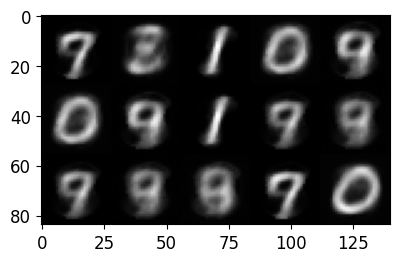

自编码器训练轮数：2，平均损失：0.0173


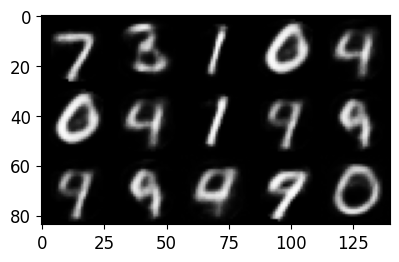

自编码器训练轮数：4，平均损失：0.0115


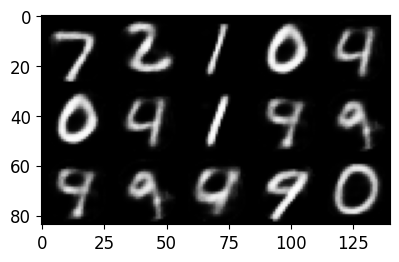

自编码器训练轮数：6，平均损失：0.0093


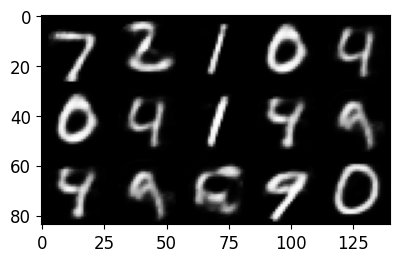

自编码器训练轮数：8，平均损失：0.0078


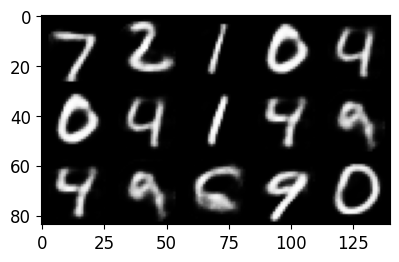

自编码器训练轮数：9，平均损失：0.0071


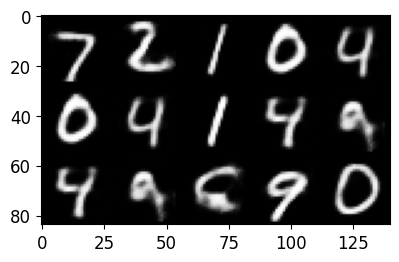

分类器训练轮数：0，平均损失：0.5439，训练准确率：85.12%
分类器训练轮数：1，平均损失：0.2170，训练准确率：93.45%
分类器训练轮数：2，平均损失：0.1789，训练准确率：94.56%
分类器训练轮数：3，平均损失：0.1565，训练准确率：95.22%
分类器训练轮数：4，平均损失：0.1419，训练准确率：95.67%
分类器训练轮数：5，平均损失：0.1306，训练准确率：95.97%
分类器训练轮数：6，平均损失：0.1216，训练准确率：96.29%
分类器训练轮数：7，平均损失：0.1147，训练准确率：96.45%
分类器训练轮数：8，平均损失：0.1102，训练准确率：96.57%
分类器训练轮数：9，平均损失：0.1082，训练准确率：96.60%
测试集准确率：96.39%
原始图像


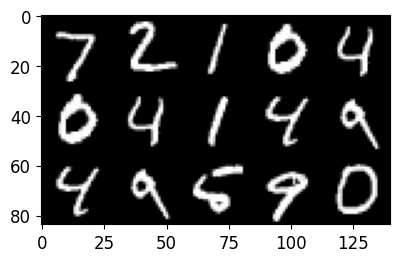

重建图像


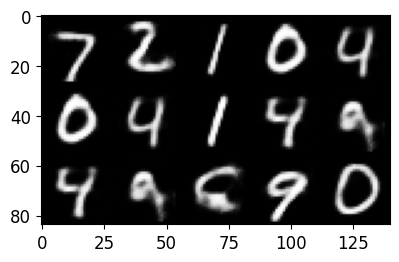

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 加载MNIST数据集
mnist_train = pd.read_csv("mnist_train.csv")  # 训练集数据
mnist_test = pd.read_csv("mnist_test.csv")    # 测试集数据

# 预处理数据：提取像素并归一化到 [0, 1]，提取标签
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255  # 训练集图像，展平为 784 维
y_train = mnist_train.iloc[:, 0].to_numpy()  # 训练集标签
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255   # 测试集图像，展平为 784 维
y_test = mnist_test.iloc[:, 0].to_numpy()    # 测试集标签
print(f'训练集大小：{len(x_train)}')  # 打印训练集样本数
print(f'测试集大小：{len(x_test)}')   # 打印测试集样本数

# 定义图像可视化函数
def display(data, m, n):
    """将图像数据按 m 行 n 列展示"""
    img = np.zeros((28 * m, 28 * n))  # 创建空白画布
    for i in range(m):
        for j in range(n):
            # 将每张图像填充到对应位置
            img[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = data[i * m + j].reshape(28, 28)
    plt.figure(figsize=(m * 1.5, n * 1.5))  # 设置画布大小
    plt.imshow(img, cmap='gray')  # 显示灰度图像
    plt.show()  # 渲染图像

# 定义多层感知机（MLP）类
class MLP(nn.Module):
    def __init__(self, layer_sizes, use_sigmoid=True):
        """初始化 MLP
        - layer_sizes: 每层神经元数量的列表
        - use_sigmoid: 是否在层间使用 Sigmoid 激活函数
        """
        super().__init__()
        self.layers = nn.ModuleList()  # 存储网络层
        num_in = layer_sizes[0]  # 输入层维度
        for num_out in layer_sizes[1:]:
            self.layers.append(nn.Linear(num_in, num_out))  # 添加全连接层
            if use_sigmoid:  # 如果启用 Sigmoid，则添加激活层
                self.layers.append(nn.Sigmoid())
            num_in = num_out  # 更新输入维度为当前输出维度

    def forward(self, x):
        """前向传播：通过所有层处理输入"""
        for layer in self.layers:
            x = layer(x)
        return x

# 定义自编码器网络
layer_sizes = [784, 256, 128, 100]  # 网络层结构：输入 784 维，逐步压缩到 100 维
encoder = MLP(layer_sizes, use_sigmoid=True)  # 编码器：压缩图像特征
decoder = MLP(layer_sizes[::-1], use_sigmoid=True)  # 解码器：从特征重建图像

# 设置训练超参数
learning_rate = 0.01  # 学习率
max_epoch = 10       # 训练轮数
batch_size = 256     # 批量大小
display_step = 2     # 每隔几轮展示一次结果
np.random.seed(0)    # 设置 NumPy 随机种子
torch.manual_seed(0) # 设置 PyTorch 随机种子

# 配置优化器：同时优化编码器和解码器参数
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# 训练自编码器
for i in range(max_epoch):
    idx = np.random.permutation(len(x_train))  # 随机打乱训练数据索引
    x_train_shuffled = x_train[idx]  # 打乱后的训练数据
    st = 0  # 批量起始索引
    ave_loss = []  # 存储每批次的损失
    while st < len(x_train):
        ed = min(st + batch_size, len(x_train))  # 批量结束索引
        X = torch.from_numpy(x_train_shuffled[st:ed]).to(torch.float32)  # 转换为张量
        Z = encoder(X)  # 编码：生成 100 维特征
        X_rec = decoder(Z)  # 解码：重建图像
        loss = 0.5 * nn.functional.mse_loss(X, X_rec)  # 计算重建损失（均方误差）
        ave_loss.append(loss.item())  # 记录损失值
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数
        st = ed  # 更新起始索引
    ave_loss = np.average(ave_loss)  # 计算平均损失
    if i % display_step == 0 or i == max_epoch - 1:  # 每隔 display_step 或最后一轮
        print(f'自编码器训练轮数：{i}，平均损失：{ave_loss:.4f}')  # 打印训练轮数和损失
        with torch.inference_mode():  # 禁用梯度计算
            X_test = torch.from_numpy(x_test[:3 * 5]).to(torch.float32)  # 取测试集前 15 张图像
            X_test_rec = decoder(encoder(X_test))  # 生成重建图像
            X_test_rec = X_test_rec.cpu().numpy()  # 转换为 NumPy 数组
        display(X_test_rec, 3, 5)  # 展示重建图像

# 提取特征：使用训练好的编码器生成特征
with torch.inference_mode():
    X_train_features = encoder(torch.from_numpy(x_train).to(torch.float32)).cpu().numpy()  # 训练集特征
    X_test_features = encoder(torch.from_numpy(x_test).to(torch.float32)).cpu().numpy()    # 测试集特征

# 定义分类器 MLP
class ClassifierMLP(nn.Module):
    def __init__(self):
        """初始化分类器：从 100 维特征预测 10 个类别"""
        super().__init__()
        self.layers = nn.ModuleList()  # 存储网络层
        self.layers.append(nn.Linear(100, 64))  # 第一层：100 维特征到 64 维
        self.layers.append(nn.Sigmoid())        # Sigmoid 激活函数
        self.layers.append(nn.Linear(64, 10))   # 输出层：10 个类别

    def forward(self, x):
        """前向传播：通过所有层处理输入"""
        for layer in self.layers:
            x = layer(x)
        return x

# 配置分类器训练
classifier = ClassifierMLP()  # 实例化分类器
optimizer_clf = torch.optim.Adam(classifier.parameters(), lr=learning_rate)  # 配置优化器
criterion = nn.CrossEntropyLoss()  # 定义交叉熵损失函数
max_epoch_clf = 10  # 分类器训练轮数

# 训练分类器
for i in range(max_epoch_clf):
    idx = np.random.permutation(len(X_train_features))  # 随机打乱特征索引
    X_train_features_shuffled = X_train_features[idx]  # 打乱后的特征
    y_train_shuffled = y_train[idx]  # 打乱后的标签
    st = 0  # 批量起始索引
    ave_loss = []  # 存储每批次损失
    correct = 0  # 统计正确预测数
    while st < len(X_train_features):
        ed = min(st + batch_size, len(X_train_features))  # 批量结束索引
        X = torch.from_numpy(X_train_features_shuffled[st:ed]).to(torch.float32)  # 转换为张量
        Y = torch.from_numpy(y_train_shuffled[st:ed]).to(torch.long)  # 标签转换为张量
        logits = classifier(X)  # 前向传播：生成分类 logits
        loss = criterion(logits, Y)  # 计算交叉熵损失
        ave_loss.append(loss.item())  # 记录损失值
        optimizer_clf.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer_clf.step()  # 更新参数
        correct += (logits.argmax(dim=1) == Y).sum().item()  # 统计正确预测数
        st = ed  # 更新起始索引
    ave_loss = np.average(ave_loss)  # 计算平均损失
    train_acc = correct / len(X_train_features)  # 计算训练准确率
    print(f'分类器训练轮数：{i}，平均损失：{ave_loss:.4f}，训练准确率：{train_acc * 100:.2f}%')  # 打印结果

# 测试分类器
with torch.inference_mode():
    X_test_tensor = torch.from_numpy(X_test_features).to(torch.float32)  # 测试集特征张量
    y_test_tensor = torch.from_numpy(y_test).to(torch.long)  # 测试集标签张量
    logits = classifier(X_test_tensor)  # 前向传播
    predictions = logits.argmax(dim=1)  # 预测类别
    accuracy = (predictions == y_test_tensor).float().mean().item()  # 计算准确率
    print(f'测试集准确率：{accuracy * 100:.2f}%')  # 打印测试准确率

# 展示原始和重建图像
print('原始图像')  # 提示信息
display(x_test, 3, 5)  # 展示测试集前 15 张原始图像
print('重建图像')  # 提示信息
X_test = torch.from_numpy(x_test[:3 * 5]).to(torch.float32)  # 取测试集前 15 张图像
X_test_rec = decoder(encoder(X_test))  # 生成重建图像
X_test_rec = X_test_rec.detach().cpu().numpy()  # 转换为 NumPy 数组
display(X_test_rec, 3, 5)  # 展示重建图像

## 习题3

自动编码器的基础结构并不一定局限于MLP，对于图像任务来说，CNN在理论上更加合适。尝试用CNN搭建自动编码器，该模型的解码部分同样与编码部分结构相同、顺序相反，并且将编码时的池化用上采样代替。

训练集大小：60000
测试集大小：10000
Epoch [1/10], Loss: 0.0188
Epoch [2/10], Loss: 0.0041
Epoch [3/10], Loss: 0.0035
Epoch [4/10], Loss: 0.0031
Epoch [5/10], Loss: 0.0029
Epoch [6/10], Loss: 0.0027
Epoch [7/10], Loss: 0.0026
Epoch [8/10], Loss: 0.0025
Epoch [9/10], Loss: 0.0024
Epoch [10/10], Loss: 0.0023


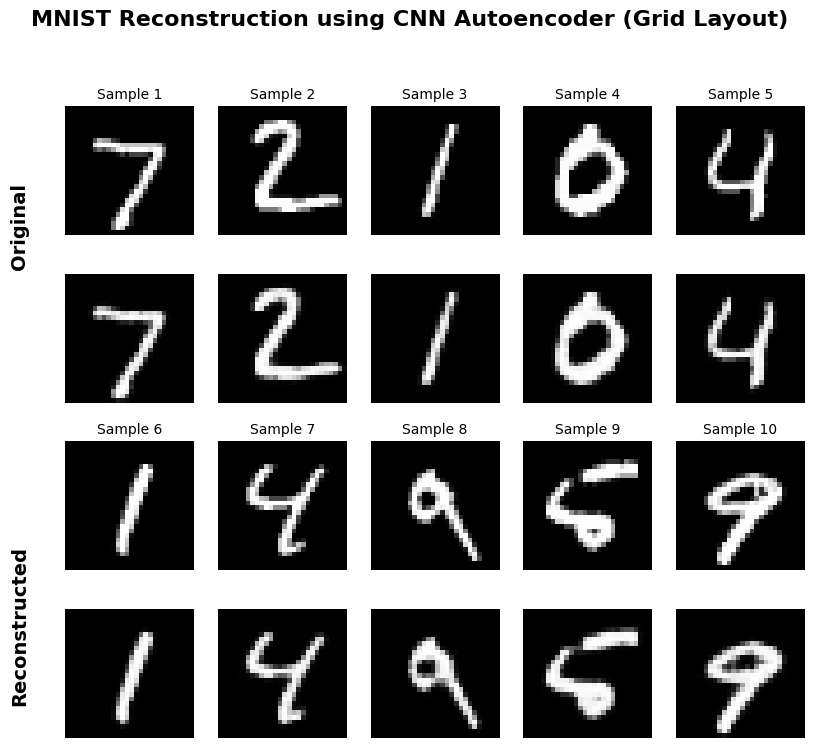

In [27]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt

# 设备选择
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 读取 MNIST CSV 数据
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test = pd.read_csv("mnist_test.csv")    

# 预处理数据：归一化并转换形状 (N, 1, 28, 28)
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 1, 28, 28).astype(np.float32) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 1, 28, 28).astype(np.float32) / 255

print(f'训练集大小：{len(x_train)}')
print(f'测试集大小：{len(x_test)}')

# 自定义 PyTorch 数据集
class MNISTDataset(data.Dataset):
    def __init__(self, images):
        self.images = torch.tensor(images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.images[idx]  # 自动编码器的目标是重建输入

# 创建 DataLoader
train_dataset = MNISTDataset(x_train)
test_dataset = MNISTDataset(x_test)

train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# CNN 自动编码器
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14

            nn.Conv2d(16, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, kernel_size=2, stride=2),  # 14x14 -> 28x28
            nn.Sigmoid()  # 归一化到 [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 初始化模型
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, images)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# 测试模型
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        break  # 只测试一个 batch

# 可视化原始图像和重建图像
images = images.cpu().numpy()
outputs = outputs.cpu().numpy()

# 可视化原始图像和重建图像
fig, axes = plt.subplots(4, 5, figsize=(10, 8), facecolor='white')

# 设置全局字体大小
plt.rcParams.update({'font.size': 12})

# 绘制网格图像
for i in range(10):
    row = i // 5 * 2  # 每两行显示一个样本的原始和重建图像
    col = i % 5
    
    # 原始图像
    axes[row, col].imshow(images[i, 0], cmap="gray", vmin=0, vmax=1)
    axes[row, col].axis("off")
    axes[row, col].set_title(f"Sample {i+1}", fontsize=10, pad=5)
    
    # 生成的重建图像
    axes[row+1, col].imshow(outputs[i, 0], cmap="gray", vmin=0, vmax=1)
    axes[row+1, col].axis("off")

# 添加左侧标注
fig.text(0.1, 0.75, "Original", fontsize=14, fontweight="bold", rotation=90, va='center')
fig.text(0.1, 0.25, "Reconstructed", fontsize=14, fontweight="bold", rotation=90, va='center')

# 添加整体标题
plt.suptitle("MNIST Reconstruction using CNN Autoencoder (Grid Layout)", fontsize=16, fontweight="bold", y=1.02)

# 调整布局，避免过于紧密
plt.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9, left=0.15)

# 显示可视化结果
plt.show()

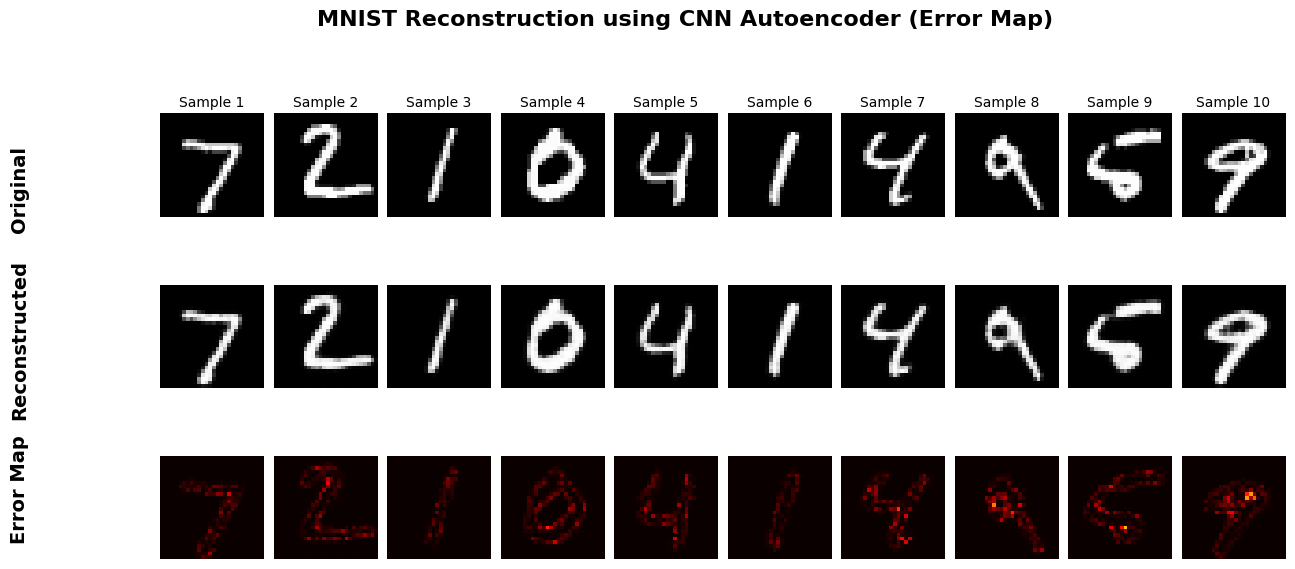

In [ ]:
# 计算误差图
error_maps = np.abs(images - outputs)

fig, axes = plt.subplots(3, 10, figsize=(15, 6), facecolor='white')

# 设置全局字体大小
plt.rcParams.update({'font.size': 12})

# 绘制原始图像、重建图像和误差图
for i in range(10):
    # 原始图像
    axes[0, i].imshow(images[i, 0], cmap="gray", vmin=0, vmax=1)
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Sample {i+1}", fontsize=10, pad=5)
    
    # 生成的重建图像
    axes[1, i].imshow(outputs[i, 0], cmap="gray", vmin=0, vmax=1)
    axes[1, i].axis("off")
    
    # 误差图
    axes[2, i].imshow(error_maps[i, 0], cmap="hot", vmin=0, vmax=1)
    axes[2, i].axis("off")

# 添加左侧标注
fig.text(0.05, 0.75, "Original", fontsize=14, fontweight="bold", rotation=90, va='center')
fig.text(0.05, 0.5, "Reconstructed", fontsize=14, fontweight="bold", rotation=90, va='center')
fig.text(0.05, 0.25, "Error Map", fontsize=14, fontweight="bold", rotation=90, va='center')

# 添加整体标题
plt.suptitle("MNIST Reconstruction using CNN Autoencoder (Error Map)", fontsize=16, fontweight="bold", y=1.05)

# 调整布局，避免过于紧密
plt.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9, left=0.15)

# 显示可视化结果
plt.show()

## 习题4

降噪编码器是自动编码器的一个变种，它主动为输入样本添加噪声，将带噪的样本给自动编码器训练，与原始样本计算重建损失。这样训练出的自动编码器就有了去噪功能。试给手写数字图像加上噪声，用降噪编码器为其去噪，观察去噪后的图像与原始图像的区别。

**代码1**

Epoch [1/10], Loss: 0.0404
Epoch [2/10], Loss: 0.0194
Epoch [3/10], Loss: 0.0151
Epoch [4/10], Loss: 0.0132
Epoch [5/10], Loss: 0.0120
Epoch [6/10], Loss: 0.0111
Epoch [7/10], Loss: 0.0104
Epoch [8/10], Loss: 0.0099
Epoch [9/10], Loss: 0.0096
Epoch [10/10], Loss: 0.0093


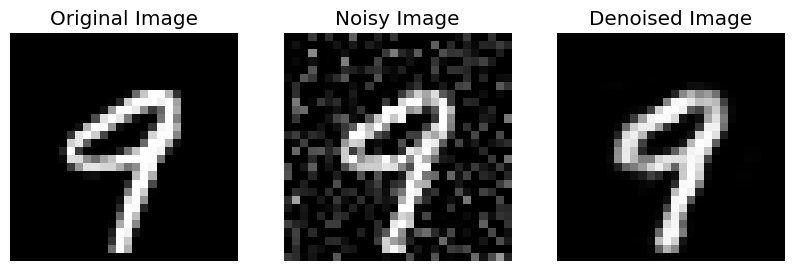

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 加载数据集
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test = pd.read_csv("mnist_test.csv")

# 提取特征和标签
x_train = mnist_train.iloc[:, 1:].to_numpy() / 255.0
y_train = mnist_train.iloc[:, 0].to_numpy()

x_test = mnist_test.iloc[:, 1:].to_numpy() / 255.0
y_test = mnist_test.iloc[:, 0].to_numpy()

# 将数据转换为张量格式
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# 定义降噪函数，添加高斯噪声
def add_noise(data, noise_factor=0.2):
    noise = torch.randn_like(data) * noise_factor
    noisy_data = data + noise
    return torch.clamp(noisy_data, 0., 1.)  # 将数据截断在 [0, 1] 范围内

# 自动编码器
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 实例化模型
model = DenoisingAutoencoder()

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 定义训练函数
def train(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs, _ = data
            noisy_inputs = add_noise(inputs)
            optimizer.zero_grad()
            outputs = model(noisy_inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# 将数据封装成 DataLoader
train_dataset = TensorDataset(x_train_tensor, torch.tensor(y_train))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 训练模型
train(model, train_loader, criterion, optimizer)

# 随机选取一张图像进行测试
index = np.random.randint(len(x_test))
test_image = x_test_tensor[index]
noisy_test_image = add_noise(test_image.unsqueeze(0))

# 使用训练好的模型对噪声图像进行去噪
with torch.no_grad():
    denoised_image = model(noisy_test_image).squeeze()

# 可视化原始图像、噪声图像和去噪图像
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(test_image.view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(noisy_test_image.view(28, 28), cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image.view(28, 28), cmap='gray')
plt.title('Denoised Image')
plt.axis('off')

plt.show()


**代码2**

训练集大小：60000
测试集大小：10000


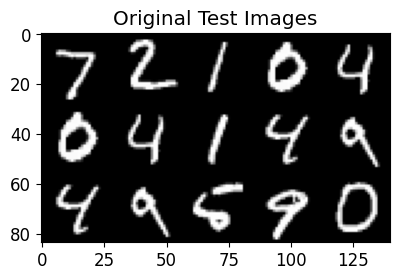

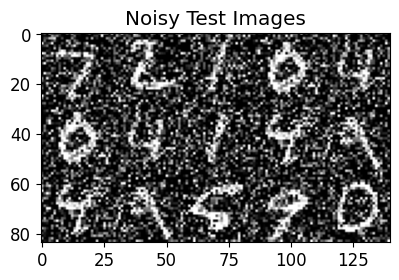

Epoch 0, Loss: 0.0323


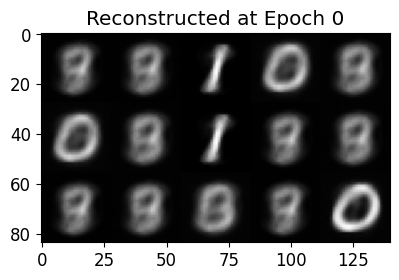

Epoch 2, Loss: 0.0210


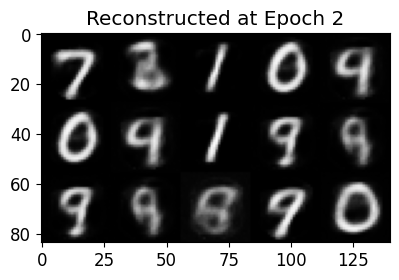

Epoch 4, Loss: 0.0147


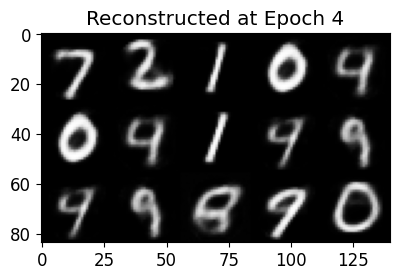

Epoch 6, Loss: 0.0124


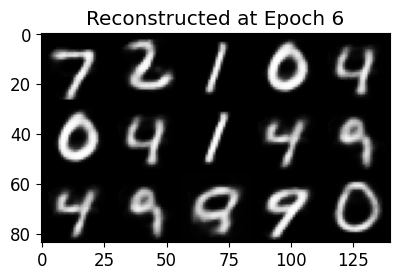

Epoch 8, Loss: 0.0110


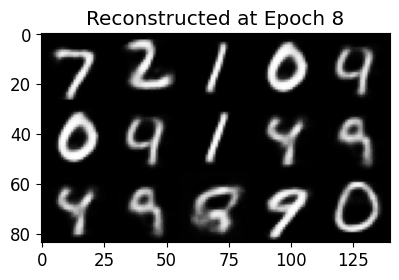

Epoch 9, Loss: 0.0105


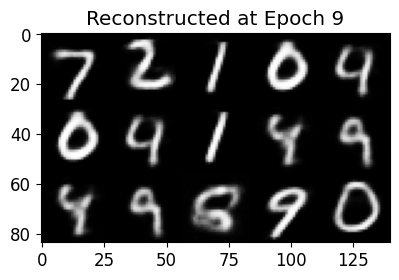

原始图像


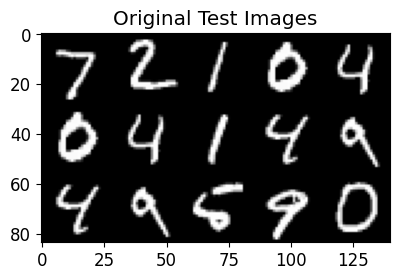

带噪图像


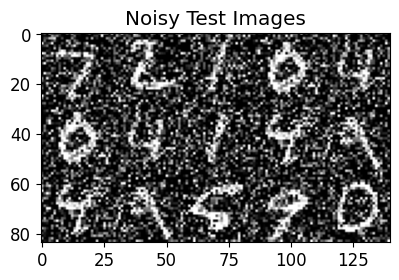

去噪后图像


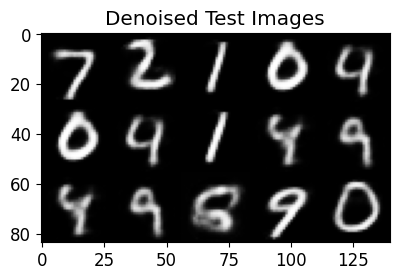

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

# 读取数据
mnist_train = pd.read_csv("mnist_train.csv")
mnist_test = pd.read_csv("mnist_test.csv")

# 预处理数据
x_train = mnist_train.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255
x_test = mnist_test.iloc[:, 1:].to_numpy().reshape(-1, 28 * 28) / 255

print(f'训练集大小：{len(x_train)}')
print(f'测试集大小：{len(x_test)}')

# 显示图像的函数
def display(data, m, n, title="Image"):
    img = np.zeros((28 * m, 28 * n))
    for i in range(m):
        for j in range(n):
            img[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = \
                data[i * m + j].reshape(28, 28)
    plt.figure(figsize=(m * 1.5, n * 1.5))
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

display(x_test, 3, 5, "Original Test Images")

# 添加噪声函数（高斯噪声）
def add_noise(data, noise_factor=0.5):
    noisy_data = data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
    return np.clip(noisy_data, 0., 1.)  # 确保仍然在 [0,1] 范围内

# 生成带噪图像
x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# 显示带噪图像
display(x_test_noisy, 3, 5, "Noisy Test Images")

# 定义 MLP 结构
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList()
        num_in = layer_sizes[0]
        for num_out in layer_sizes[1:]:
            self.layers.append(nn.Linear(num_in, num_out))
            self.layers.append(nn.Sigmoid())  # 使用 Sigmoid 归一化
            num_in = num_out

    def forward(self, x):
        for l in self.layers:
            x = l(x)
        return x

# 定义编码器和解码器
layer_sizes = [784, 256, 128, 100]
encoder = MLP(layer_sizes)
decoder = MLP(layer_sizes[::-1])

# 训练参数
learning_rate = 0.01
max_epoch = 10
batch_size = 256
display_step = 2

# 设定优化器
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

# 训练降噪自动编码器
np.random.seed(0)
torch.manual_seed(0)

for i in range(max_epoch):
    idx = np.random.permutation(len(x_train))
    x_train = x_train[idx]
    x_train_noisy = x_train_noisy[idx]  # 确保噪声数据和原始数据对齐
    st = 0
    ave_loss = []
    
    while st < len(x_train):
        ed = min(st + batch_size, len(x_train))
        noisy_X = torch.from_numpy(x_train_noisy[st: ed]).to(torch.float32)
        clean_X = torch.from_numpy(x_train[st: ed]).to(torch.float32)  # 目标是无噪声的
        
        Z = encoder(noisy_X)  
        X_rec = decoder(Z)  
        loss = 0.5 * nn.functional.mse_loss(X_rec, clean_X)  # 计算重建误差（与干净图像比较）
        ave_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        st = ed

    ave_loss = np.mean(ave_loss)
    if i % display_step == 0 or i == max_epoch - 1:
        print(f'Epoch {i}, Loss: {ave_loss:.4f}')
        
        with torch.no_grad():
            X_test_noisy = torch.from_numpy(x_test_noisy[:3 * 5]).to(torch.float32)
            X_test_denoised = decoder(encoder(X_test_noisy)).cpu().numpy()

        display(X_test_denoised, 3, 5, f"Reconstructed at Epoch {i}")

# 最终测试
print("原始图像")
display(x_test, 3, 5, "Original Test Images")

print("带噪图像")
display(x_test_noisy, 3, 5, "Noisy Test Images")

print("去噪后图像")
X_test_noisy = torch.from_numpy(x_test_noisy[:3 * 5]).to(torch.float32)
X_test_denoised = decoder(encoder(X_test_noisy)).detach().cpu().numpy()
display(X_test_denoised, 3, 5, "Denoised Test Images")
